<a href="https://colab.research.google.com/github/ileunam/Prophet-calidad-de-aire-Curic-/blob/main/Prophet_calidad_de_aire_Curic%C3%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython.core.display
import matplotlib


def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [ ]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
url="https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
df = pd.read_csv(url, sep=';', header=None, skiprows=1, names=['Date', 'Time', 'Validated', 'Preliminaries', 'NotValidated', 'Unnamed'])
df.sample(10)

,Date,Time,Validated,Preliminaries,NotValidated,Unnamed
2491,121018,2000,NaN,NaN,NaN,NaN
63040,190915,1700,3,NaN,NaN,NaN
28502,151007,1500,"10,9879",NaN,NaN,NaN
23048,150222,900,9,NaN,NaN,NaN
23540,150314,2100,37,NaN,NaN,NaN
44672,170811,900,30,NaN,NaN,NaN
58065,190220,1000,13,NaN,NaN,NaN
58860,190325,1300,19,NaN,NaN,NaN
28742,151017,1500,"11,8607",NaN,NaN,NaN
30771,160110,400,NaN,NaN,"15,62",NaN


Acá se limpian los datos y se dejan solo dos columnas

In [ ]:
import numpy as np

#Las horas las deja en cuatro dígitos
def parse_fourdigits(x):
  x = str(x)
  while len(x) != 4:
    x = '0' + x

  return x

#Elige el valor de contaminación que no es nulo entre las tres columnas
def choose_pollution():
  conditions = [
                ~pd.isnull(df['Validated']), 
                ~pd.isnull(df['Preliminaries']),
                ~pd.isnull(df['NotValidated'])
               ]        

  choices = [df['Validated'], df['Preliminaries'], df['NotValidated']]
  df['Pollution'] = np.select(conditions, choices, default=np.nan)


#Se aplica el parseo a las horas
df['Time'] = df['Time'].apply(parse_fourdigits)

#Une fechas y horas y los convierte a tipo datetime
df['Datetime'] = df['Date'].apply(str) + df['Time'].apply(str)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%y%m%d%H%M')

#Se elige el valor distinto de NaN y si todos son NaN, se deja NaN
choose_pollution()

#Se transforman los valores de contaminación a tipo float
df['Pollution'] = df['Pollution'].apply(lambda x : float(str(x).replace(',', '.')))





#Se eliminan todas las columnas que no se usarán
df.drop(['Date', 'Time', 'Unnamed', 'Validated', 'Preliminaries', 'NotValidated'], axis='columns', inplace=True)
df.sample(10)

,Datetime,Pollution
60384,2019-05-28 01:00:00,18.0000
71198,2020-08-20 15:00:00,19.0000
10898,2013-10-04 03:00:00,10.0000
77155,2021-04-25 20:00:00,29.0000
26567,2015-07-19 00:00:00,10.1477
41187,2017-03-19 04:00:00,18.0500
11584,2013-11-01 17:00:00,8.0000
15804,2014-04-26 13:00:00,21.0000
59373,2019-04-15 22:00:00,76.0000
74244,2020-12-25 13:00:00,9.0000


Se grafican los datos

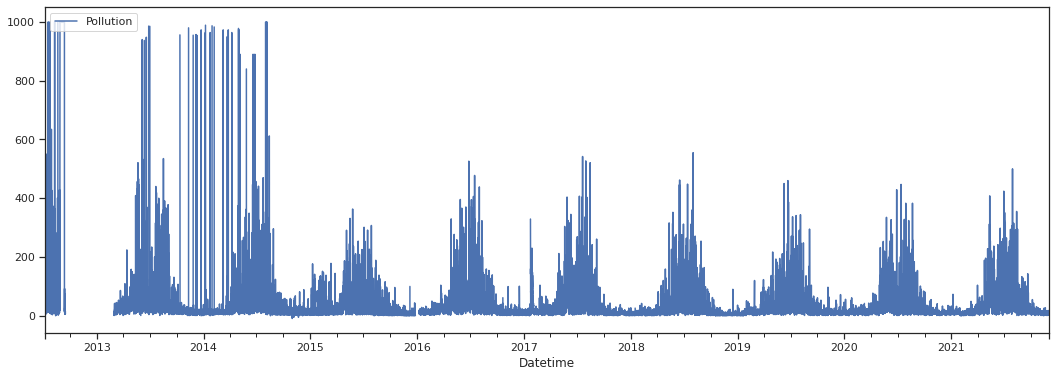

In [ ]:
fig, ax = plt.subplots(figsize=(18,6)) ## ahora comenzamos hacer las visualizaciones tomando los datos y gráficas de los con respecto al tiempo
df.plot(x="Datetime", y="Pollution", ax=ax)
plt.legend(loc='upper left')

plt.savefig('images/intro-visualization.png'); ## recuerda crear la carpeta 'images'


Se separan los datos de entrenamiento y de testing

Utilizando Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
import holidays

years = range(2012, 2021)
all_holidays = holidays.CL(years=years)


In [ ]:
df_holidays = pd.DataFrame.from_dict(all_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

Se consideran los incendios masivos en Chile en el verano del 2017 en Chile


In [ ]:
from datetime import date

changepoints = {
    date(2017,1,1): "Massive forest fires in 2017 summer in Chile"
}

Entrenar Prophet

In [ ]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,
    holidays=df_holidays,
    changepoints=list(changepoints.keys()),
    changepoint_prior_scale=0.01
    ).fit(df)

Hacer predicciones

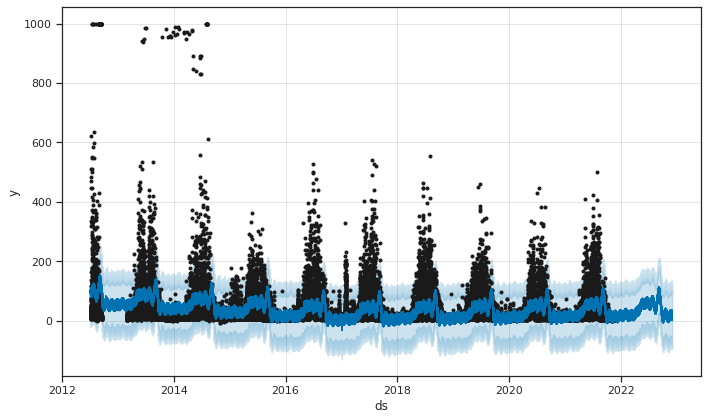

In [ ]:

future = m.make_future_dataframe(periods=8760, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

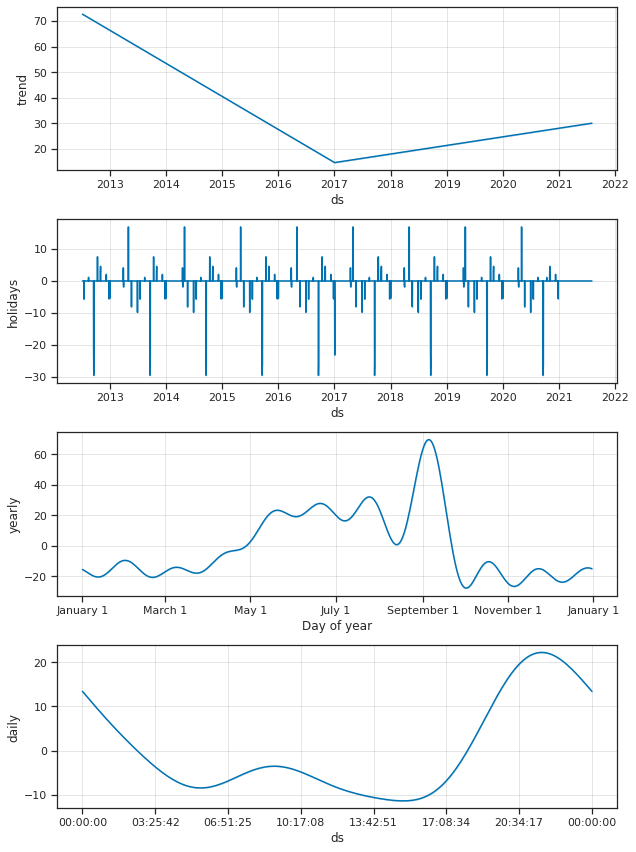

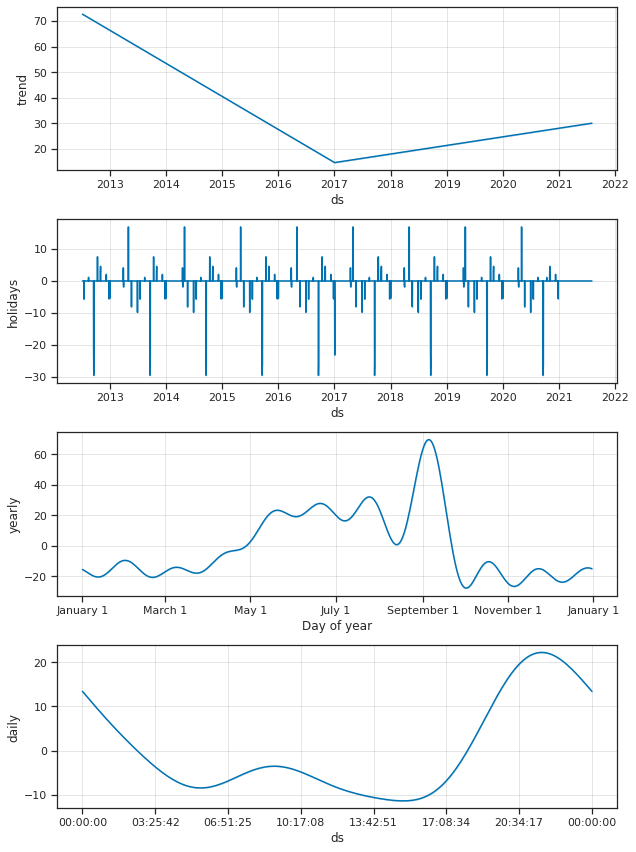

In [ ]:
m.plot_components(forecast)

ValueError: ignored

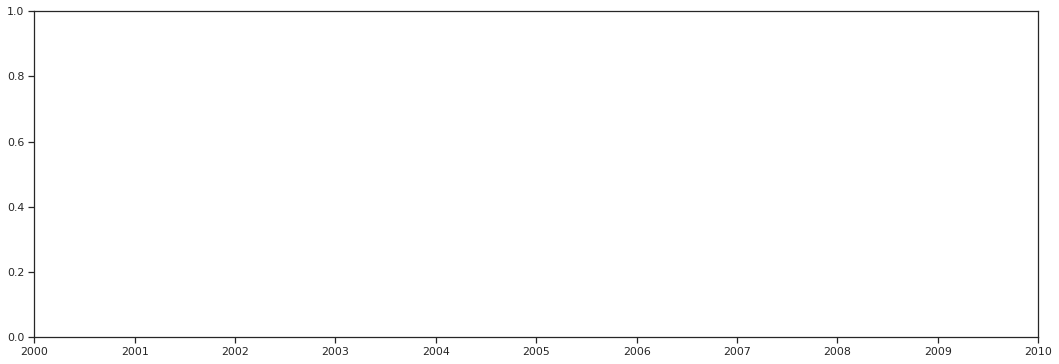

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].Datetime.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].Datetime.values[0])), c='red', ls='--', lw=1)
df.plot(x="Datetime", y="Pollution", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('images/prophet-forecast-testrange.png')
plt.show();

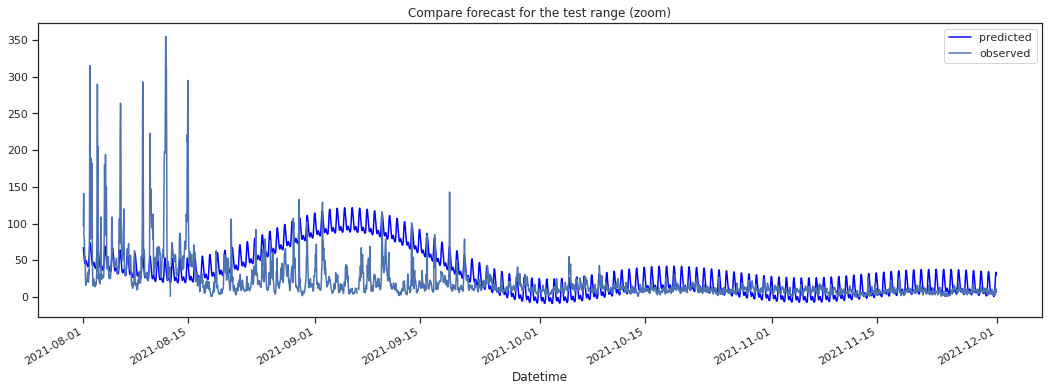

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].Datetime.values), yhat_test, color="blue", label="predicted")

df.loc[test_range].plot(x="Datetime", y="Pollution", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')


plt.savefig('images/prophet-forecast-testrange-zoom.png')
plt.show();